In [36]:
import numpy as np
import scipy.constants as spc
import matplotlib.pyplot as plt

In [37]:
class Mag_Dipole():
    def __init__(self, m):
        self.m = m # initialize the dipole moment

    def visualize(self):
        return

    def get_field(self, r, version = 'vector'):
        
        r = r.reshape(max(r.shape[0], 1), r.shape[-1]) # make sure the position vector is the correct shape for vectorization (must be 2D!)
        
        B_field = np.array((spc.mu_0/(4*np.pi))*(3*r*(np.dot(r, m).reshape(r.shape[0],1))/(np.linalg.norm(r, axis = 1).reshape(r.shape[0],1)**5) - m/(np.linalg.norm(r, axis = 1).reshape(r.shape[0],1)**3))) # calc the B-field

        if version == 'scalar':
            return np.linalg.norm(B_field, axis = 1).reshape(B_field.shape[0],1)
        elif version == 'vector':
            return B_field
        else:
            raise Exception("'%s is not a valid version, please use either 'scalar' or 'vector''" % version)
        

    
    def gen_data(self, r_dist, num_data_pts, version = 'vector'):
                
        r_list = r_dist*np.random.rand(num_data_pts) # generate random radial distances within specified radius
        theta_list = 2*np.pi*np.random.rand(num_data_pts) # generate random polar angles
        phi_list = np.pi*np.random.rand(num_data_pts) # generate random azimuthal angles

        x_list = r_list*np.sin(phi_list)*np.cos(theta_list) # switch to cartesian
        y_list = r_list*np.sin(phi_list)*np.sin(theta_list) # switch to cartesian
        z_list = r_list*np.cos(phi_list) # switch to cartesian

        xyz = np.stack((x_list, y_list, z_list), axis=-1) # group data points together in their own arrays (this is position vector from dipole to measurement)

        B_fields = self.get_field(xyz, version)
        
        label = np.hstack((xyz, np.repeat(self.m.reshape(1,3), len(xyz), axis = 0))) # keep track of the labels corresponding to the B-field

        return B_fields, label

In [38]:
m = np.array([0,0,5])
dipole = Mag_Dipole(m)

In [39]:
r = np.array([[0,0,1], [0,1,0], [1,0,1]])
# r = np.array([[0,0,1]])
print(dipole.get_field(r, version = 'scalar'))
print()
print(dipole.get_field(r, version = 'vector'))

[[1.00000000e-06]
 [5.00000000e-07]
 [2.79508497e-07]]

[[ 0.00000000e+00  0.00000000e+00  1.00000000e-06]
 [ 0.00000000e+00  0.00000000e+00 -5.00000000e-07]
 [ 2.65165043e-07  0.00000000e+00  8.83883477e-08]]


In [40]:
r_dist, num = 5, 1000
data, label = dipole.gen_data(r_dist, num, version = 'scalar')
print(data[0], label[0])

[6.10448969e-07] [ 0.8192814   0.45181486 -0.07065579  0.          0.          5.        ]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_yticks'

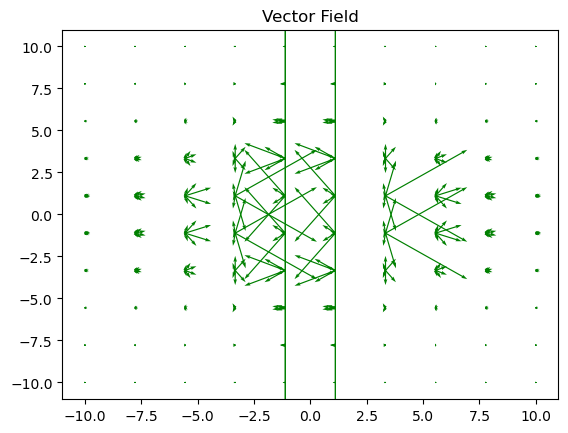

In [230]:
# Meshgrid

m = np.array([1e10,0,0])
dipole = Mag_Dipole(m)

R = 10
num_pts = 10

space_x = np.linspace(-R, R, num_pts)
space_y = np.linspace(-R, R, num_pts)
space_z = np.linspace(-R, R, num_pts)
# space = space[np.where(abs(space) > 2.5)]

x, y, z = np.meshgrid(space_x, space_y, space_z)
r = np.array(np.meshgrid(space_x, space_y, space_z)).T.reshape(-1,3)
  



fields = dipole.get_field(r)
# print(fields)

u, v, w = fields[:,0], fields[:,1], fields[:,2]

# # Directional vectors
# u = -y/np.sqrt(x**2 + y**2)
# v = x/(x**2 + y**2)
  
# Plotting Vector Field with QUIVER
plt.quiver(x, y, u, v, color='g')
plt.title('Vector Field')
plt.yticks(y, v)
  
# Setting x, y boundary limits
# plt.xlim(-7, 7)
# plt.ylim(-7, 7)
  
# Show plot with grid
plt.grid()
plt.show()

# Build a NN

In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

import tensorflow as tf

In [60]:
model = Sequential()
model.add(Dense(2048, input_shape=(3,), activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(6))

def custom_loss(y_pred, y_true):

    xyz_pred, xyz_true = y_pred[:3], y_true[:3]
    m_pred, m_true = y_pred[3:], y_true[3:]

    res = tf.reduce_mean(tf.add(tf.square(tf.subtract(xyz_pred,xyz_true)), tf.square(tf.subtract(xyz_pred,xyz_true))))

    return res

model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])


In [61]:
model.fit(data, label, epochs=5, batch_size=10)

Epoch 1/5
100/100 [==============================] - 5s 48ms/step - loss: 179705.5000 - accuracy: 0.9890
Epoch 2/5
100/100 [==============================] - 7s 67ms/step - loss: 5.1881 - accuracy: 0.9980
Epoch 3/5
100/100 [==============================] - 6s 59ms/step - loss: 8.5972 - accuracy: 0.9990
Epoch 4/5
100/100 [==============================] - 6s 60ms/step - loss: 9573.1748 - accuracy: 0.9980
Epoch 5/5
100/100 [==============================] - 6s 62ms/step - loss: 6375.8701 - accuracy: 0.9970


In [62]:
test= dipole.get_field(np.array([[4,5,6]]))
test

array([[6.91951553e-10, 8.64939441e-10, 2.97923585e-10]])

In [63]:
model.predict(test)

1/1 [==============================] - 0s 44ms/step


array([[ 0.04630638, -0.09633145,  0.04751302, -0.1105911 , -0.10547149,
         5.0561624 ]], dtype=float32)